In [132]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt


In [133]:
df = pd.read_csv('weatherHistory.csv')
print(df.shape)
display(df.head())

(96453, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Cleaning the data

In [134]:
#We're only doing temperature and humidity
#Apparent temperature will prob get swapped with inside temperature
df['Temperature (F)'] = (df['Temperature (C)'] * (9.0/5.0)) + 32
df['Apparent Temperature (F)'] = (df['Apparent Temperature (C)'] * (9.0/5.0)) + 32
df = df.drop(['Precip Type', 'Wind Speed (km/h)', 'Summary', 'Wind Speed (km/h)', 'Temperature (C)', 'Apparent Temperature (C)', 'Formatted Date', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary'], axis=1)
df.reset_index(inplace=True, drop=True)

print(df.shape)
display(df)

(96453, 3)


,Humidity,Temperature (F),Apparent Temperature (F)
0,0.89,49.05,45.30
1,0.86,48.84,45.01
2,0.89,48.88,48.88
3,0.83,46.92,42.70
4,0.83,47.76,44.56
...,...,...,...
96448,0.43,78.83,78.83
96449,0.48,76.25,76.25
96450,0.56,71.67,71.67
96451,0.60,70.74,70.74


## Deciding on scores for probability of opening the window

In [135]:
hot_outside_temp = 80
cold_outside_temp = 65
hot_inside_temp = 70
cold_inside_temp = 65
cold_humidity = 0.4
hot_humidity = 0.6

def score_temp(row):
    if row['Temperature (F)'] < cold_outside_temp:
        score = 0.0
    elif row['Temperature (F)'] >= cold_outside_temp and row['Temperature (F)'] < hot_outside_temp:
        score = 0.15
    else:
        score = 0.3
    t_score = (row['Temperature (F)'] / 100 + score) / 2
    return t_score

def score_apparent_temp(row):
    if row['Apparent Temperature (F)'] < cold_inside_temp:
        score = 0.0
    elif row['Apparent Temperature (F)'] >= cold_inside_temp and row['Apparent Temperature (F)'] < hot_inside_temp:
        score = 0.1
    else:
        score = 0.2
    a_score = (row['Apparent Temperature (F)'] / 100 + score) / 2
    return a_score

def score_humidity(row):
    if row['Humidity'] < cold_humidity or row['Humidity'] > hot_humidity:
        score = 0.0
    else:
        score = 0.3
    h_score = (row['Humidity'] / 100 + score) / 2
    return h_score


df['Likelihood of Opening Window'] = df.apply(score_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_apparent_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_humidity, axis=1)
df['Likelihood of Opening Window'] = df['Likelihood of Opening Window'].clip(lower=0, upper=1)

display(df.head(20))

,Humidity,Temperature (F),Apparent Temperature (F),Likelihood of Opening Window
0,0.89,49.05,45.30,0.47620
1,0.86,48.84,45.01,0.47355
2,0.89,48.88,48.88,0.49325
3,0.83,46.92,42.70,0.45225
4,0.83,47.76,44.56,0.46575
5,0.85,48.60,44.80,0.47125
6,0.95,45.92,41.94,0.44405
7,0.89,47.79,43.75,0.46215
8,0.82,51.48,51.48,0.51890
9,0.72,56.79,56.79,0.57150


In [ ]:
hot_outside_temp = 80
cold_outside_temp = 65
hot_inside_temp = 70
cold_inside_temp = 65
cold_humidity = 0.4
hot_humidity = 0.6

def score_temp(row):
    if row['Temperature (F)'] < cold_outside_temp:
        score = 0.0
    elif row['Temperature (F)'] >= cold_outside_temp and row['Temperature (F)'] < hot_outside_temp:
        score = 0.15
    else:
        score = 0.3
    t_score = (row['Temperature (F)'] / 100 + score) / 2
    return t_score

def score_apparent_temp(row):
    if row['Apparent Temperature (F)'] < cold_inside_temp:
        score = 0.0
    elif row['Apparent Temperature (F)'] >= cold_inside_temp and row['Apparent Temperature (F)'] < hot_inside_temp:
        score = 0.1
    else:
        score = 0.2
    a_score = (row['Apparent Temperature (F)'] / 100 + score) / 2
    return a_score

def score_humidity(row):
    if row['Humidity'] < cold_humidity or row['Humidity'] > hot_humidity:
        score = 0.0
    else:
        score = 0.3
    h_score = (row['Humidity'] / 100 + score) / 2
    return h_score


df['Likelihood of Opening Window'] = df.apply(score_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_apparent_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_humidity, axis=1)
df['Likelihood of Opening Window'] = df['Likelihood of Opening Window'].clip(lower=0, upper=1)

display(df.head(20))

,Humidity,Temperature (F),Apparent Temperature (F),Likelihood of Opening Window
0,0.89,49.05,45.30,0.47620
1,0.86,48.84,45.01,0.47355
2,0.89,48.88,48.88,0.49325
3,0.83,46.92,42.70,0.45225
4,0.83,47.76,44.56,0.46575
5,0.85,48.60,44.80,0.47125
6,0.95,45.92,41.94,0.44405
7,0.89,47.79,43.75,0.46215
8,0.82,51.48,51.48,0.51890
9,0.72,56.79,56.79,0.57150


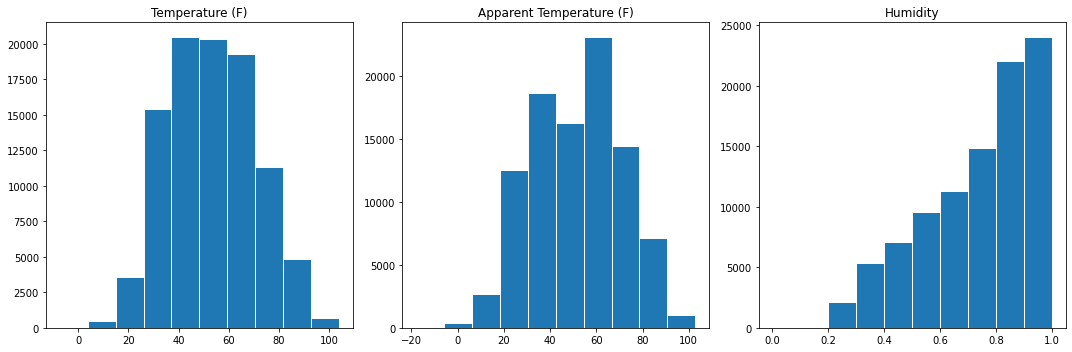

In [136]:
col = ['Temperature (F)', 'Apparent Temperature (F)', 'Humidity']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, column in enumerate(col):
    temp_df = pd.DataFrame(df[column], columns=[column])
    ax = axes[i]  
    ax.hist(temp_df[column], edgecolor='white')  
    ax.set_title(column)     

plt.tight_layout()  
plt.show()         

## Train and test model

In [137]:
data_df = df.drop('Likelihood of Opening Window', axis=1)
target_df = pd.DataFrame(df['Likelihood of Opening Window'], columns=['Likelihood of Opening Window'])

x_train, x_test, y_train, y_test = train_test_split(data_df, target_df, test_size=0.2, random_state=69)
print(x_train.shape)
print(x_test.shape)

(77162, 3)
(19291, 3)


## Standardizing data

In [138]:
col = ['Temperature (F)', 'Apparent Temperature (F)', 'Humidity']
feature_scaler = RobustScaler()
feature_scaler.fit_transform(x_train[col])
feature_scaler.fit_transform(x_test[col])
df_x_train_standardized = pd.DataFrame(x_train, columns = col)
df_x_test_standardized = pd.DataFrame(x_test, columns = col)

target_scaler = RobustScaler()
target_scaler.fit_transform(y_train)
target_scaler.fit_transform(y_test)
df_y_train_standardized = pd.DataFrame(y_train, columns = ['Likelihood of Opening Window'])
df_y_test_standardized = pd.DataFrame(y_test, columns = ['Likelihood of Opening Window'])

x_train[col] = df_x_train_standardized
x_test[col] = df_x_test_standardized
y_train = df_y_train_standardized
y_test = df_y_test_standardized


<Axes: >

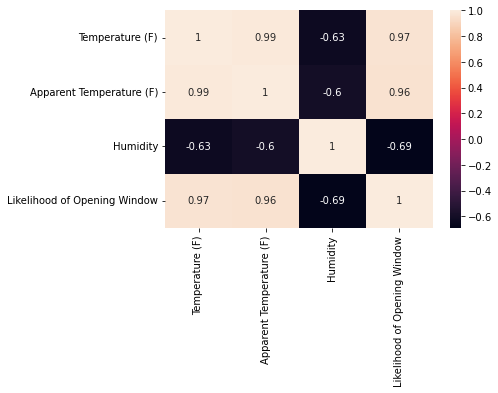

In [139]:
#Negative correlations (when one variable increases, the other variable tends to decrease)
sns.heatmap(pd.concat([df_x_train_standardized, y_train], axis=1).corr(), annot=True)

In [ ]:
hot_outside_temp = 80
cold_outside_temp = 65
hot_inside_temp = 70
cold_inside_temp = 65
cold_humidity = 0.4
hot_humidity = 0.6

def score_temp(row):
    if row['Temperature (F)'] < cold_outside_temp:
        score = 0.0
    elif row['Temperature (F)'] >= cold_outside_temp and row['Temperature (F)'] < hot_outside_temp:
        score = 0.15
    else:
        score = 0.3
    t_score = (row['Temperature (F)'] / 100 + score) / 2
    return t_score

def score_apparent_temp(row):
    if row['Apparent Temperature (F)'] < cold_inside_temp:
        score = 0.0
    elif row['Apparent Temperature (F)'] >= cold_inside_temp and row['Apparent Temperature (F)'] < hot_inside_temp:
        score = 0.1
    else:
        score = 0.2
    a_score = (row['Apparent Temperature (F)'] / 100 + score) / 2
    return a_score

def score_humidity(row):
    if row['Humidity'] < cold_humidity or row['Humidity'] > hot_humidity:
        score = 0.0
    else:
        score = 0.3
    h_score = (row['Humidity'] / 100 + score) / 2
    return h_score


df['Likelihood of Opening Window'] = df.apply(score_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_apparent_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_humidity, axis=1)
df['Likelihood of Opening Window'] = df['Likelihood of Opening Window'].clip(lower=0, upper=1)

display(df.head(20))

,Humidity,Temperature (F),Apparent Temperature (F),Likelihood of Opening Window
0,0.89,49.05,45.30,0.47620
1,0.86,48.84,45.01,0.47355
2,0.89,48.88,48.88,0.49325
3,0.83,46.92,42.70,0.45225
4,0.83,47.76,44.56,0.46575
5,0.85,48.60,44.80,0.47125
6,0.95,45.92,41.94,0.44405
7,0.89,47.79,43.75,0.46215
8,0.82,51.48,51.48,0.51890
9,0.72,56.79,56.79,0.57150


In [140]:
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_train)
y_train_pred = pd.DataFrame(predictions, columns=['Predicted Likelihood of Opening Window'])

# Mean Squred Error
mse = mean_squared_error(y_train, y_train_pred)
print('Mean squared error(Train) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_train, y_train_pred))
print('Root mean squared error(Train) :', round(rmsq, 4))

# Accuracy
score = lm.score(x_train, y_train)
print('Explained variance of the predictions(Train) :', round(score * 100, 4))

Mean squared error(Train) : 0.0034
Root mean squared error(Train) : 0.0583
Explained variance of the predictions(Train) : 94.3982


In [141]:
predictions = lm.predict(x_test)
y_pred = pd.DataFrame(predictions, columns=['Predicted Likelihood of Opening Window'])

#Mean Squred Error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error(Testing) :', round(mse, 4))

# Root Mean Squared Error
rmsq = sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error(Testing) :', round(rmsq, 4))

# Accuracy
score = lm.score(x_test, y_test)
print('Explained variance of the predictions(Testing) :', round(score * 100, 4))

Mean squared error(Testing) : 0.0034
Root mean squared error(Testing) : 0.0583
Explained variance of the predictions(Testing) : 94.4241


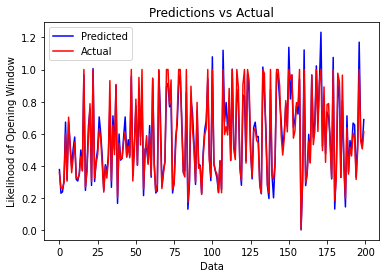

In [142]:
# Plot the first 20 predicted values
plt.plot(y_pred[:200], label='Predicted', color='blue')

# Plot the first 20 actual values
plt.plot(y_test[:200].values, label='Actual', color='red')

# Labeling and title
plt.xlabel('Data')
plt.ylabel('Likelihood of Opening Window')
plt.title('Predictions vs Actual')

# Legend
plt.legend()

# Show the plot
plt.show()


In [143]:
hot_outside_temp = 80
cold_outside_temp = 65
hot_inside_temp = 70
cold_inside_temp = 65
cold_humidity = 0.4
hot_humidity = 0.6

def score_temp(row):
    if row['Temperature (F)'] < cold_outside_temp:
        score = 0.0
    elif row['Temperature (F)'] >= cold_outside_temp and row['Temperature (F)'] < hot_outside_temp:
        score = 0.25
    else:
        score = 0.5
    t_score = (row['Temperature (F)'] / 100 + score) / 2
    return t_score

def score_apparent_temp(row):
    if row['Apparent Temperature (F)'] < cold_inside_temp:
        score = 0.0
    elif row['Apparent Temperature (F)'] >= cold_inside_temp and row['Apparent Temperature (F)'] < hot_inside_temp:
        score = 0.15
    else:
        score = 0.3
    a_score = (row['Apparent Temperature (F)'] / 100 + score) / 2
    return a_score

def score_humidity(row):
    if row['Humidity'] < cold_humidity or row['Humidity'] > hot_humidity:
        score = 0.0
    else:
        score = 0.5
    h_score = (row['Humidity'] / 100 + score) / 2
    return h_score


df['Likelihood of Opening Window'] = df.apply(score_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_apparent_temp, axis=1)
df['Likelihood of Opening Window'] += df.apply(score_humidity, axis=1)
df['Likelihood of Opening Window'] = df['Likelihood of Opening Window'].clip(lower=0, upper=1)

display(df.head(20))

,Humidity,Temperature (F),Apparent Temperature (F),Likelihood of Opening Window
0,0.89,49.05,45.30,0.47620
1,0.86,48.84,45.01,0.47355
2,0.89,48.88,48.88,0.49325
3,0.83,46.92,42.70,0.45225
4,0.83,47.76,44.56,0.46575
5,0.85,48.60,44.80,0.47125
6,0.95,45.92,41.94,0.44405
7,0.89,47.79,43.75,0.46215
8,0.82,51.48,51.48,0.51890
9,0.72,56.79,56.79,0.57150


In [149]:
new_data = pd.DataFrame({
    'Humidity': [0.5],
    'Temperature (F)': [80],
    'Apparent Temperature (F)': [80],
})
prediction = model.predict(new_data)
val = prediction[0].item() * 100.0
print(f"Sarah is {val:.2f}% likely to open the window")

Sarah is 95.61% likely to open the window
